# Pr√©diction de la demande en √©lectricit√©
<img src="Images/header_image.jpg" width=750>

# Objectif

Mon but est de d√©terminer la consommation en √©lectricit√© pour la France sur une p√©riode d'un an. Pours les industriels de l'√©nergie, ajuster l'offre en fonction de la demande est important. En effet, il n'existe actuellement pas de m√©thode pour stocker de l'√©lectricit√© en masse et les √©lectrons se d√©placent √† la vitesse de la lumi√®re. En outre, la demande en √©lectricit√© est influenc√©e par de nombreux facteurs tels que la m√©t√©o.

Sources :
- https://www.youtube.com/watch?v=ypD6f4K0LTU
- https://business.weather.com/products/load-forecasts

# Les donn√©es

- Donn√©es de consommation d'√©lectricit√© mensuelles : 
   - Institution fournisant les donn√©es :  Le *RTE* (*R√©seau de transport et d'√©lectricit√©*)
     - "RTE a √©t√© cr√©√© le 1er juillet 2000 avec pour missions d‚Äôentretenir, d‚Äôexploiter et de d√©velopper le r√©seau de transport d‚Äô√©lectricit√© √† haute et tr√®s haute tension de mani√®re ind√©pendante. C'est √† cette √©poque un service d‚ÄôEDF, avec une gestion, une comptabilit√© et un management s√©par√©s. Il s'agit de pr√©parer l‚Äôouverture du march√© de l‚Äô√©lectricit√© et l‚Äôarriv√©e de nouveaux producteurs."
     - "Le 1er septembre 2005, nous devenons une filiale du Groupe EDF, en application de la loi du 9 ao√ªt 2004 relative au service public de l‚Äô√©lectricit√© et du gaz et aux entreprises √©lectriques et gazi√®res. L‚Äôobligation d‚Äôind√©pendance de RTE vis-√†-vis du reste du Groupe est r√©affirm√©e et garantit la neutralit√© de RTE au regard de l‚Äôensemble des producteurs d‚Äô√©lectricit√©. Elle passe par un code de bonne conduite, dont le respect est v√©rifi√© annuellement par la Commission de R√©gulation de l‚Äô√ânergie (CRE)."
   - Nom fichier : *eCO2mix_RTE_energie_M.xls.xlsx*
   - Lien source : http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement
   - Cl√©s primaires :
     - Mois	
     - Qualit√©
     - Territoire
   - P√©riode : Janvier 2010 √† D√©cembre 2018 inclus 
- Donn√©es m√©t√©o pour corriger les donn√©es de l'effet temp√©rature : 
   - Institution fournisant les donn√©es :  Cegibat
     - "Cegibat, le centre d'expertise de GRDF, a pour mission d‚Äôinformer et d‚Äôoutiller l‚Äôensemble des professionnels du b√¢timent (bureaux d'√©tudes, installateurs, architectes, directeurs techniques, responsables de patrimoine, responsables √©nergie, exploitants‚Ä¶) sur la r√©glementation gaz naturel et l‚Äôefficacit√© √©nerg√©tique." 
   - Nom du fichier : *calcul_DJU_chauffage.xlsx*
   - Lien source : https://cegibat.grdf.fr/simulateur/calcul-dju
   - Cl√©s primaire : 
     - Ann√©e
   - M√©thode de calcul : "Professionnels de l'√©nergie"
   - Temp√©rature de r√©f√©rence : 18¬∞C
   - Station m√©t√©o : Roissy
   - P√©riode : Janvier 2009 √† D√©cembre 2018 inclus 

# Mission 0 : chargement et d√©couverte des donn√©es

Nous allons essayer de r√©pondre aux questions suivantes :
- Combien de lignes y a-t-il dans le jeu de donn√©es ?
- Combien de colonnes y a-t-il ?
- De quels types de donn√©es sont les champs?
- Les donn√©es sont-elles compl√®tes? Y a-t-il des valeurs nulles? Devons-nous d√©duire des valeurs?
- Quelle est la d√©finition des variables?
- Quelles sont les r√©serves concernant les donn√©es?

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data Viz
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

# Mod√©lisation
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from scipy.optimize import minimize # for function minimization

# Autres
import copy
from itertools import product
from tqdm import tqdm_notebook

## D√©couverte du fichier de consommation d'√©lectricit√©

In [2]:
raw_df_energy =  pd.read_excel("Data/eCO2mix_RTE_energie_M.xls.xlsx")

raw_df_energy.info()
raw_df_energy.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 22 columns):
Mois                                        985 non-null object
Qualit√©                                     985 non-null object
Territoire                                  985 non-null object
Production totale                           985 non-null int64
Production nucl√©aire                        620 non-null float64
Production thermique totale                 985 non-null int64
Production thermique charbon                682 non-null float64
Production thermique fioul                  985 non-null int64
Production thermique gaz                    985 non-null int64
Production hydraulique                      985 non-null int64
Production √©olien                           985 non-null int64
Production solaire                          985 non-null int64
Production bio-√©nergies                     985 non-null int64
Consommation totale                         985 non-null int64
So

Mois              Qualit√©               Territoire  Production totale  \
0   0000-00  Donn√©es consolid√©es                Grand-Est               7296   
1   0000-00  Donn√©es d√©finitives       Nouvelle-Aquitaine               4523   
2   0000-00  Donn√©es d√©finitives     Auvergne-Rh√¥ne-Alpes               8890   
3   0000-00  Donn√©es d√©finitives  Bourgogne-Franche-Comt√©                152   
4   0000-00  Donn√©es d√©finitives                 Bretagne                197   
5   0000-00  Donn√©es d√©finitives      Centre-Val de Loire               6346   
6   0000-00  Donn√©es d√©finitives                   France              41255   
7   0000-00  Donn√©es d√©finitives            Ile-de-France                148   
8   0000-00  Donn√©es d√©finitives                Occitanie               2398   
9   0000-00  Donn√©es d√©finitives                Normandie               5554   
10  0000-00  Donn√©es d√©finitives          Hauts-de-France               3637   
11  0000-00  Donn√©es d√©finitives                     PACA               1265   
12  0000-00  Donn√©es d√©finitives         Pays-de-la-Loire                712   
13  2010-01  Donn√©es consolid√©es                   France              56542   
14  2010-02  Donn√©es consolid√©es                   France              50406   
15  2010-03  Donn√©es consolid√©es                   France              51071   
16  2010-04  Donn√©es consolid√©es                   France              41693   
17  2010-05  Donn√©es consolid√©es                   France              39847   
18  2010-06  Donn√©es consolid√©es                   France              40217   
19  2010-07  Donn√©es consolid√©es                   France              41064   

    Production nucl√©aire  Production thermique totale  \
0                 5505.0                          864   
1                 3740.0                           26   
2                 5946.0                           32   
3                    NaN                           19   
4                    NaN                            3   
5                 6191.0                            0   
6                29938.0                         2683   
7                    NaN                            5   
8                  823.0                            0   
9                 5222.0                          204   
10                2508.0                          750   
11                   NaN                          125   
12                   NaN                          544   
13               40313.0                         8801   
14               36316.0                         6822   
15               35984.0                         7250   
16               31294.0                         3568   
17               29372.0                         2843   
18               29575.0                         2366   
19               31744.0                         2953   

    Production thermique charbon  Production thermique fioul  \
0                          153.0                           8   
1                            NaN                           9   
2                            4.0                          17   
3                            0.0                           0   
4                            NaN                           3   
5                            NaN                           0   
6                          582.0                         206   
7                            0.0                           4   
8                            NaN                           0   
9                           57.0                          23   
10                           1.0                           0   
11                          -1.0                          11   
12                         366.0                          20   
13                        2928.0                        1690   
14                        1893.0                        1175   
15                        1994.0                        1275

In [3]:
df_energy = raw_df_energy[['Mois', 'Qualit√©', 'Territoire', 'Consommation totale']]
df_energy = df_energy[df_energy['Territoire'] == "France"]
df_energy = df_energy[df_energy['Mois'] != "0000-00"]
df_energy["Mois"] = pd.to_datetime(df_energy['Mois']).dt.to_period('M')

df_energy.info()
df_energy.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 13 to 978
Data columns (total 4 columns):
Mois                   108 non-null period[M]
Qualit√©                108 non-null object
Territoire             108 non-null object
Consommation totale    108 non-null int64
dtypes: int64(1), object(2), period[M](1)
memory usage: 4.2+ KB


Mois              Qualit√© Territoire  Consommation totale
13  2010-01  Donn√©es consolid√©es     France                56342
14  2010-02  Donn√©es consolid√©es     France                48698
15  2010-03  Donn√©es consolid√©es     France                48294
16  2010-04  Donn√©es consolid√©es     France                38637
17  2010-05  Donn√©es consolid√©es     France                37284
18  2010-06  Donn√©es consolid√©es     France                34567
19  2010-07  Donn√©es consolid√©es     France                36031
20  2010-08  Donn√©es consolid√©es     France                33069
21  2010-09  Donn√©es consolid√©es     France                35104
22  2010-10  Donn√©es consolid√©es     France                40918
23  2010-11  Donn√©es consolid√©es     France                46532
24  2010-12  Donn√©es consolid√©es     France                57600
25  2011-01  Donn√©es consolid√©es     France                53873
26  2011-02  Donn√©es consolid√©es     France                45937
27  2011-03  Donn√©es consolid√©es     France                45543
28  2011-04  Donn√©es consolid√©es     France                35442
29  2011-05  Donn√©es consolid√©es     France                35107
30  2011-06  Donn√©es consolid√©es     France                33771
31  2011-07  Donn√©es consolid√©es     France                34204
32  2011-08  Donn√©es consolid√©es     France                32625

In [4]:
# Doublons
df_energy['Mois'].describe()

count         108
unique        108
top       2012-08
freq            1
Name: Mois, dtype: object

Il n'y a pas de doublons, ni de valeurs manquantes de le dataframe "df_energy".

----------

Nous sommes int√©ress√©s seulement par l'√©volution de l'attribut "consommation totale". Selon le document de synth√®se de *RTE*  (le lien est [ici](https://www.rte-france.com/fr/article/bilans-electriques-nationaux)), la consommation en √©lectricit√© est exprim√©e en gigawatt-heure (GWh). On utilise plus commun√©ment le kilowatt-heure, un kWh √©quivaut √† 1 kilowatt (1 kW) de puissance maintenue pendant 1 heure, soit 3,6 m√©gajoules.

In [5]:
# Supression des colonnes inutiles
df_energy = df_energy[['Mois', 'Consommation totale']]
df_energy = df_energy.rename(columns={'Consommation totale': 'conso(GWh)',
                                      'Mois': 'mois'})

df_energy.info()
df_energy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 13 to 978
Data columns (total 2 columns):
mois          108 non-null period[M]
conso(GWh)    108 non-null int64
dtypes: int64(1), period[M](1)
memory usage: 2.5 KB


mois  conso(GWh)
13  2010-01       56342
14  2010-02       48698
15  2010-03       48294
16  2010-04       38637
17  2010-05       37284

## D√©couverte du fichier des donn√©es m√©t√©o


In [6]:
raw_df_weather = pd.read_excel("Data/calcul_DJU_chauffage.xlsx", skiprows=11)

raw_df_weather.info()
raw_df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 14 columns):
Unnamed: 0    11 non-null int64
JAN           11 non-null float64
F√âV           11 non-null float64
MAR           11 non-null float64
AVR           11 non-null float64
MAI           11 non-null float64
JUN           11 non-null float64
JUI           11 non-null float64
AO√õ           11 non-null float64
SEP           11 non-null float64
OCT           11 non-null float64
NOV           11 non-null float64
D√âC           11 non-null float64
Total         11 non-null float64
dtypes: float64(13), int64(1)
memory usage: 1.3 KB


Unnamed: 0    JAN    F√âV    MAR    AVR    MAI   JUN   JUI   AO√õ    SEP  \
0        2019    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0    0.0   
1        2018  324.9  453.6  333.6  146.3   97.5  34.6   6.2  18.9   71.7   
2        2017  499.6  298.6  227.9  227.2  102.5  29.8  20.0  28.5   82.0   
3        2016  384.6  341.8  352.1  244.5  125.9  52.1  23.6  23.2   34.6   
4        2015  414.0  388.3  307.4  187.5  125.0  55.2  25.3  23.3  101.6   

     OCT    NOV    D√âC   Total  
0    0.0    0.0    0.0   184.3  
1  149.2  297.6  346.0  2280.1  
2  122.4  302.9  390.4  2331.6  
3  198.4  310.3  418.6  2509.7  
4  202.4  212.5  256.1  2298.5

In [7]:
df_weather = raw_df_weather.rename(columns={'Unnamed: 0': 'Ann√©e',
                                            "JAN" : "01",
                                            "F√âV" : "02",
                                            "MAR" : "03",
                                            "AVR" : "04",
                                            "MAI" : "05",
                                            "JUN" : "06",
                                            "JUI" : "07",
                                            "AO√õ" : "08",
                                            "SEP" : "09",
                                            "OCT" : "10",
                                            "NOV" : "11",
                                            "D√âC" : "12"})
df_weather.drop(columns=['Total'], inplace=True)
df_weather.columns

Index(['Ann√©e', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12'],
      dtype='object')

In [8]:
df_weather = pd.melt(df_weather, 
                     id_vars=['Ann√©e'], 
                     value_vars=['01', '02', '03', '04', '05', '06', 
                                 '07', '08', '09', '10','11', '12'])

df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
Ann√©e       132 non-null int64
variable    132 non-null object
value       132 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ KB


Ann√©e variable  value
0   2019       01    0.0
1   2018       01  324.9
2   2017       01  499.6
3   2016       01  384.6
4   2015       01  414.0

L'attribut "value" correspond aux DJU servant √† corriger les donn√©es de l'effet temp√©rature. Le degr√© jour :
> est une valeur repr√©sentative de l‚Äô√©cart entre la temp√©rature d‚Äôune journ√©e donn√©e et un seuil de temp√©rature pr√©√©tabli (18 ¬∞C dans le cas des DJU ou Degr√© Jour Unifi√©). Somm√©s sur une p√©riode, ils permettent de calculer les besoins de chauffage et de climatisation d‚Äôun b√¢timent.

Plus le nombre de DJU est important, plus le climat a √©t√© froid sur la p√©riode √©tudi√©e. Il existe deux m√©thodes pour calculer les DJU :
- M√©thode m√©t√©o : DJU = 18 - (temp√©rature_min + temp√©rature_max) / 2
- M√©thode professionnels de l'√©nergie. Je ne la d√©taillerai pas ici, car elle est plus complexe. J'ai choisi cette derni√®re pour ce projet d'analyse de donn√©es.

Sources :
- https://cegibat.grdf.fr/simulateur/calcul-dju
- http://services.meteofrance.com/e-boutique/climatologie/dju-detail.html
- https://www.abcclim.net/degres-jour-dju.html

In [9]:
df_weather["mois"] = df_weather["Ann√©e"].astype(str) + '-' + df_weather["variable"].astype(str)
df_weather.drop(columns=['Ann√©e', 'variable'], inplace=True)
df_weather["mois"] = pd.to_datetime(df_weather['mois']).dt.to_period('M')
df_weather = df_weather.rename(columns={'value': 'dju'})

df_weather.info()
df_weather.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
dju     132 non-null float64
mois    132 non-null period[M]
dtypes: float64(1), period[M](1)
memory usage: 2.2 KB


dju     mois
127  363.5  2013-12
128  362.7  2012-12
129  331.8  2011-12
130  551.1  2010-12
131  438.8  2009-12

## Cr√©ation Dataframe 
Il est plus simple de regrouper les deux dataframes pour travailler efficacement dessus.

In [10]:
df_all = pd.merge(df_energy, df_weather, left_on='mois', right_on='mois', how='left')

df_all.index = df_all['mois']
df_all.info()
df_all.tail(10)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 108 entries, 2010-01 to 2018-12
Freq: M
Data columns (total 3 columns):
mois          108 non-null period[M]
conso(GWh)    108 non-null int64
dju           108 non-null float64
dtypes: float64(1), int64(1), period[M](1)
memory usage: 3.4 KB


mois  conso(GWh)    dju
mois                               
2018-03  2018-03       48484  333.6
2018-04  2018-04       36236  146.3
2018-05  2018-05       33949   97.5
2018-06  2018-06       32553   34.6
2018-07  2018-07       34514    6.2
2018-08  2018-08       32384   18.9
2018-09  2018-09       32620   71.7
2018-10  2018-10       37052  149.2
2018-11  2018-11       43814  297.6
2018-12  2018-12       47562  346.0

## Analyses univari√©es

In [11]:
df_all.describe()

conso(GWh)         dju
count    108.000000  108.000000
mean   40378.333333  202.495370
std     7266.069563  146.580197
min    31004.000000    6.200000
25%    33933.000000   59.625000
50%    37630.500000  186.800000
75%    46463.000000  325.600000
max    57600.000000  551.100000

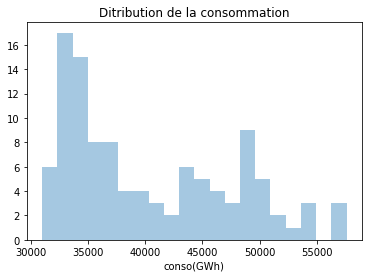

In [12]:
sns.distplot(df_all['conso(GWh)'], kde=False, bins=20)
plt.title("Ditribution de la consommation")
plt.show()

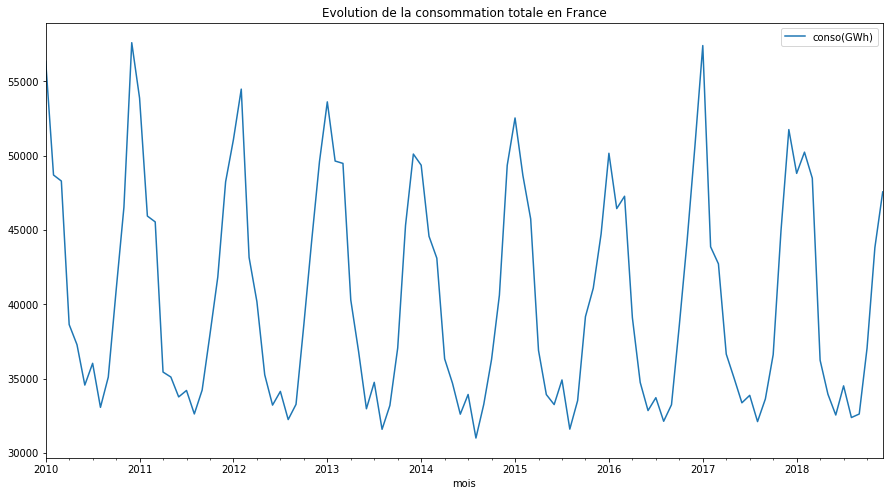

In [13]:
df_all[['mois','conso(GWh)']].plot('mois', figsize=(15,8))
plt.title("Evolution de la consommation totale en France")
plt.show()

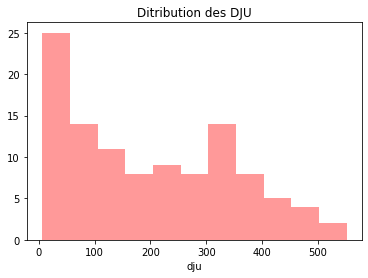

In [14]:
sns.distplot(df_all['dju'], kde=False, bins=11, color="r")
plt.title("Ditribution des DJU")
plt.show()

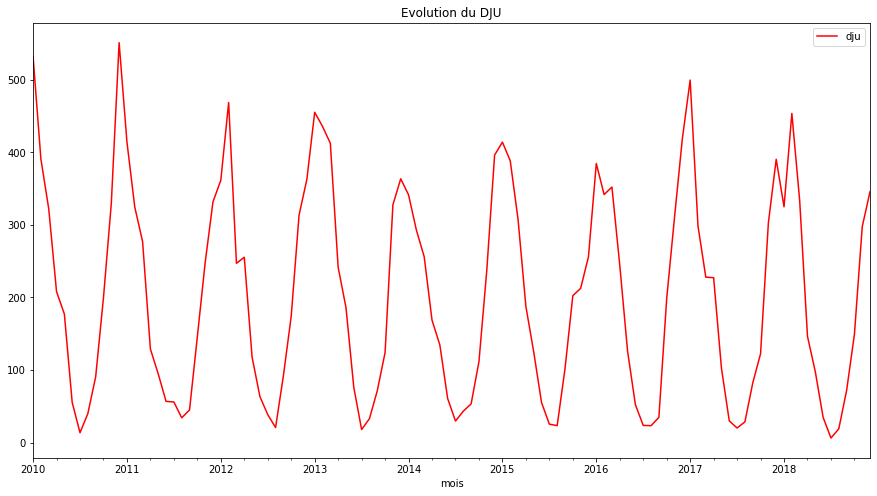

In [15]:
dju_not_null = df_all['dju'] != 0
df_all.loc[dju_not_null , ['mois','dju']].plot('mois', figsize=(15,8), color="r")
plt.title("Evolution du DJU")
plt.show()

Les graphiques de la consommation totale et de la DJU sont tr√®s proches, il semble qu'il y ait une forte corr√©lation entre ces deux variables. D'autre part, il ne semble pas avoir d'outliers dans les variables √©tudi√©es.

# Mission 1 : correction de la consommation mensuelle de l'effet temp√©rature

Nous allons maintenant corriger les donn√©es de consommation mensuelles de l'effet temp√©rature (dues au chauffage √©lectrique) en utilisant une r√©gression lin√©aire.  Nous appelons cela, la correction climatique :
>La correction climatique consiste √† pond√©rer les consommations de chauffage sur la base des donn√©es climatiques annuelles de la station m√©t√©o. L‚Äôobjectif est de rendre les ann√©es comparables entre elle, quelle qu‚Äôait √©t√© la rudesse de l‚Äôhiver. En ramenant les consommations de chauffage √† un climat de r√©f√©rence, caract√©ris√© par les DJU, on supprime ainsi les variations imputables √† la rigueur climatique.


Sources :
- http://www.gpso-energie.fr/conseils/analyser-ses-consommations-dju
- http://alpestat.com/lexique/html/_correction_climatique.html
- http://perso.ens-lyon.fr/lise.vaudor/autocorrelation-de-series-temporelles-ou-spatiales/
- https://www.youtube.com/watch?v=y5HG8ZQ_mfE&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=1
- https://www.quora.com/Why-cant-you-use-linear-regression-for-time-series-data
- https://www.quora.com/Data-Science-Can-machine-learning-be-used-for-time-series-analysis

## Application de la r√©gression lin√©aire

Sources :
- https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
- https://pythonfordatascience.org/linear-regression-python/
- https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/

In [16]:
X_constant = sm.add_constant(df_all['dju'])
lin_reg = sm.OLS(df_all['conso(GWh)'], X_constant).fit()
lin_reg.summary()

C:\Users\CGRM\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conso(GWh)   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1886.
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           2.42e-69
Time:                        11:37:59   Log-Likelihood:                -954.57
No. Observations:                 108   AIC:                             1913.
Df Residuals:                     106   BIC:                             1919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.061e+04    277.226    110.420      0.000    3.01e+04    3.12e+04
dju           48.2334      1.111     43.424      0.000      46.031      50.436
==============================================================================
Omnibus:                        0.641   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.365
Skew:                           0.133   Prob(JB):                        0.833
Kurtosis:                       3.102   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Respect des hypoth√®ses de la  RL

La r√©gression lin√©aire fait plusieurs hypoth√®ses sur les donn√©es, telles que:
- Variables explicatives quantitatives - Les donn√©es doit √™tre quantitatives ; c'est le cas dans notre projet.
- Lin√©arit√© des donn√©es - La relation entre le(s) pr√©dicteur(s) et le variable pr√©dite est suppos√©e √™tre lin√©aire.
- Normalit√© des r√©sidus - Les erreurs de pr√©diction sont suppos√©es √™tre normalement distribu√©es.
- Homog√©n√©it√© de la variance des r√©sidus - Les r√©sidus sont suppos√©s avoir une variance constante (homosc√©dasticit√©). 
- Ind√©pendance des r√©sidus - Les r√©sidus ne doivent pas s'influencer les uns des autres.

Sources :
- https://boostedml.com/2018/08/testing-linear-regression-assumptions-the-kaggle-housing-price-dataset.html
- https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/
- https://pythonfordatascience.org/linear-regression-python/

### Lin√©arit√© des donn√©es

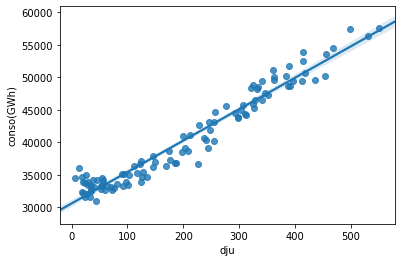

In [17]:
sns.regplot(x="dju", y="conso(GWh)", data=df_all)
plt.show()

Visuellement, la relation entre les DJU et la consommation para√Æt lin√©aire.

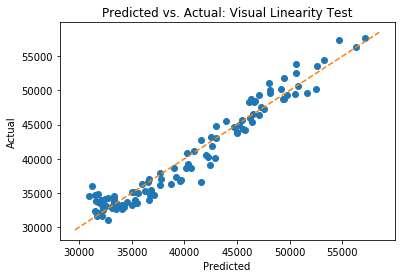

In [18]:
def abline(slope, intercept):
    """Plot a line from slope and intercept, borrowed from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# fit an OLS model to data
lin_reg = sm.OLS(df_all['conso(GWh)'], X_constant).fit()
# predict y values for training data
y_hat = lin_reg.predict()
# plot predicted vs actual
plt.plot(y_hat, df_all['conso(GWh)'],'o')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual: Visual Linearity Test')
abline(1,0)
plt.show()

In [19]:
sms.linear_harvey_collier(lin_reg)

Ttest_1sampResult(statistic=-1.158421070042484, pvalue=0.24934543645980192)

L'hypoth√®se nulle du test de Harvey-Collier est que la r√©gression est correctement mod√©lis√©e en √©tant lin√©aire. Dans notre cas, la valeur-p √©tant largement sup√©rieur √† 1%, nous ne rejetons pas l'hypoth√®se nulle : il y a bien une relation lin√©aire entre le DJU et la consommation totale.

### Normalit√© des r√©sidus

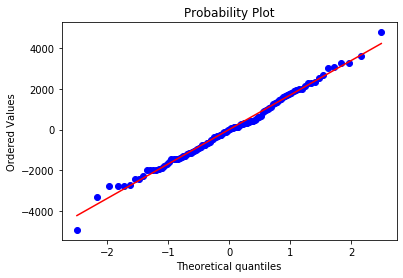

In [20]:
# Quantiles of the residuals against the quantiles of the normal distribution
resid = lin_reg.resid
scipystats.probplot(resid, dist="norm", plot=pylab)
pylab.show()

In [21]:
print(stats.diagnostic.kstest_normal(resid, pvalmethod='approx'))

(0.05736260834897666, 0.2)


Les quantiles des r√©sidus  ont l'air de suivre les quantiles de la distribution normale sur le graphique. De plus, la p-valeur pour le test de Kolmogorov-Smirnov est de 20%, nous ne rejetons pas l'hypoth√®ses nulle de normalit√©. Par cons√©quent, les r√©sidus suivent une loi normale.

### Homog√©n√©it√© de la variance des r√©sidus

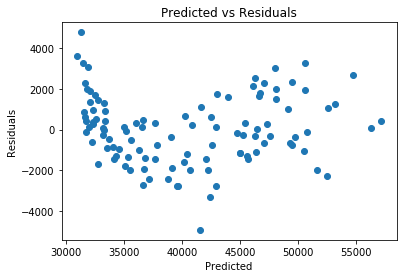

In [22]:
plt.scatter(lin_reg.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.show()

In [23]:
# https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
stats.diagnostic.het_white(lin_reg.resid, lin_reg.model.exog)

(0.04751111636933647,
 0.9765243839788765,
 0.02310584624018381,
 0.9771640166793769)

Le test de White est un test statistique qui teste si la variance des erreurs d'un mod√®le de r√©gression est constante (homosc√©dasticit√©). Au vu de la p-valeur, nous en d√©duisons que la variance des erreurs du mod√®le de r√©gression est constante.

### Ind√©pendance des r√©sidus

In [24]:
stools.durbin_watson(lin_reg.resid)

1.7781530043780844

La statistique du test de Durbin-Watson indique l'autocorr√©lation des r√©sidus. Cette statistique est toujours comprise entre 0 et 4. Plus la statistique est proche de 0, plus l'auto-corr√©lation positive est av√©r√©e. Plus on se rapproche de 4, plus il y a de preuves d'une auto-corr√©lation n√©gative. Proche de 2, la statistique indique qu'il n'y a pas d'auto-corr√©lation.

Dans ce projet, cette statisitique est proche de 2, les r√©sidus sont donc ind√©pendants.

### Significativit√© des param√®tres

In [25]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conso(GWh)   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1886.
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           2.42e-69
Time:                        11:38:00   Log-Likelihood:                -954.57
No. Observations:                 108   AIC:                             1913.
Df Residuals:                     106   BIC:                             1919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.061e+04    277.226    110.420      0.000    3.01e+04    3.12e+04
dju           48.2334      1.111     43.424      0.000      46.031      50.436
==============================================================================
Omnibus:                        0.641   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.365
Skew:                           0.133   Prob(JB):                        0.833
Kurtosis:                       3.102   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Les coefficients d√©crivent la relation math√©matique entre chaque variable ind√©pendante et la variable d√©pendante. Les valeurs-p des coefficients indiquent si ces relations sont statistiquement significatives. Ici, les param√®tres sont significatifs, les p-valeurs sont largement inf√©rieurs √† 1%.

R¬≤ est le pourcentage de variance de la variable cible qui est expliqu√©e par la r√©gression lin√©aire. 95% de la variance expliqu√©e dans notre cas. Les autres facteurs non consid√©r√©s dans le mod√®le sont responsables de 5% de la variance.


## Correction de la consommation mensuelle

L'√©quation de la r√©gression lin√©aire pour la consommation est la suivante :
>conso = ùõº + ùõΩ.dju(**valeur**) + ùúñ(**r√©sidus**)

Pour avoir la consommation mensuelle corrig√©e de l'effet temp√©rature (dues au chauffage √©lectrique) , il suffit de passer √† l'op√©ration suivante : 
>conso_revue =  conso - ùõΩ.dju(**valeur**)

In [26]:
df_all['conso_revue(GWh)'] = df_all['conso(GWh)'] - lin_reg.params[1] * df_all['dju']
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 108 entries, 2010-01 to 2018-12
Freq: M
Data columns (total 4 columns):
mois                108 non-null period[M]
conso(GWh)          108 non-null int64
dju                 108 non-null float64
conso_revue(GWh)    108 non-null float64
dtypes: float64(2), int64(1), period[M](1)
memory usage: 4.2 KB


mois  conso(GWh)    dju  conso_revue(GWh)
mois                                                 
2010-01  2010-01       56342  531.8      30691.462976
2010-02  2010-02       48698  390.7      29853.199670
2010-03  2010-03       48294  322.3      32748.366147
2010-04  2010-04       38637  208.0      28604.446970
2010-05  2010-05       37284  177.1      28741.859897

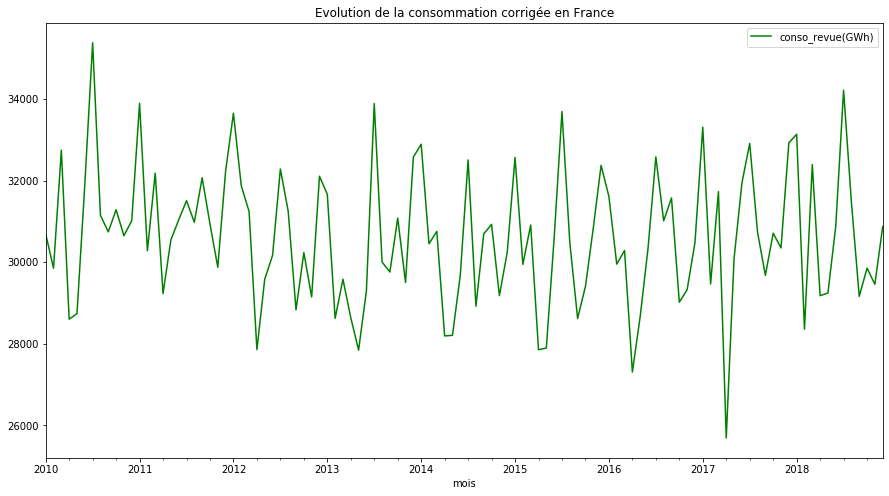

In [27]:
df_all[['mois','conso_revue(GWh)']].plot('mois', figsize=(15,8), color='g')
plt.title("Evolution de la consommation corrig√©e en France")
plt.show()

In [28]:
df_all.loc[df_all['conso_revue(GWh)'].idxmin()]

mois                2017-04
conso(GWh)            36650
dju                   227.2
conso_revue(GWh)    25691.4
Name: 2017-04, dtype: object

Le mois d'avril 2017 est un outlier. Dans son analyse de la consommation du mois d'avril 2017, voici ce qu'indique la *RTE* :
>La consommation brute est en recul par rapport √† avril 2016 (-6,2%) du fait de temp√©ratures plus douces. Bien que ce mois d‚Äôavril se soit r√©v√©l√© plus froid que la normale (-0,8¬∞C) il a √©t√© en hausse par rapport au mois d‚Äôavril 2016 (+0,7¬∞C). Corrig√©e de l‚Äôal√©a climatique la consommation fran√ßaise annuelle d‚Äô√©lectricit√© est en tr√®s l√©g√®re diminution (-0,3%).

Source : https://www.rte-france.com/fr/eco2mix/analyses-mensuelles#

# Mission 2 : d√©saisonnalisation de la consommation

## Moyenne mobile

Nous allons effectuer une d√©saisonnalisation de la consommation obtenue apr√®s correction, gr√¢ce aux moyennes mobiles. Selon l'Insee, une moyenne mobile :
>permet de ¬´ lisser ¬ª une s√©rie de valeurs exprim√©es en fonction du temps (s√©rie chronologique). Elle permet d'√©liminer les fluctuations les moins significatives. On calcule des moyennes mobiles d'ordre 1, d'ordre 2, d'ordre 3, etc. L'ordre est le nombre de p√©riodes (ann√©es, trimestres, mois...) sur lesquelles la moyenne mobile est calcul√©e.

En clair, on utilise ce proc√©d√© pour faire appara√Ætre la/les tendance(s) en effa√ßant la saisonnalit√© et le bruit al√©atoire. Choisir le bon ordre est semblable au dilemme biais/variance en *machine learning*. Il existe plusieurs types de moyennes glissantes :
- Arithm√©tique / pond√©r√©e / exponentielle
- Centr√©e ou non-centr√©e

Autres liens :
- https://medium.com/fintechexplained/forecasting-time-series-explained-5cc773b232b6
- https://www.youtube.com/watch?v=l5A0ZDMzsv8

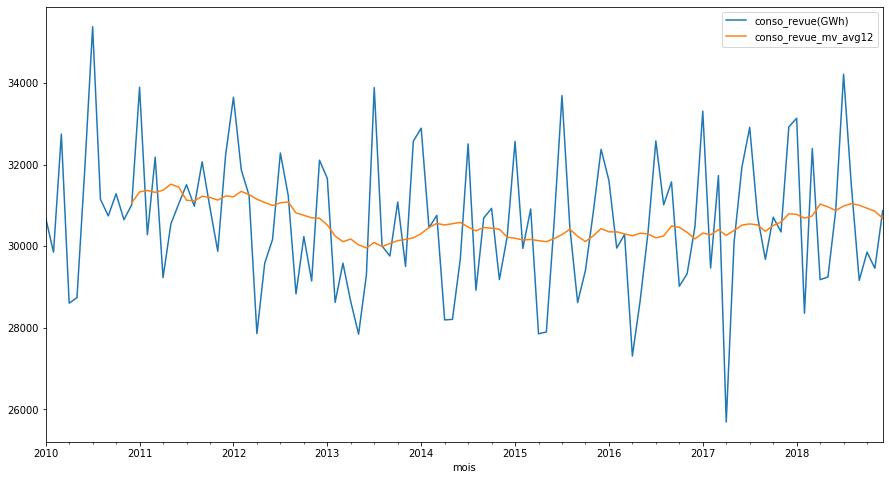

In [29]:
df_all['conso_revue_mv_avg12'] = df_all['conso_revue(GWh)'].rolling(window=12).mean()
df_all[['mois', 'conso_revue(GWh)', 'conso_revue_mv_avg12']].plot('mois', figsize=(15,8))
plt.show()

J'ai choisi d'utiliser une moyenne mobile non-centr√©e d'ordre 12, car il y a 12 mois dans une ann√©e et car la courbe est visuellement explicite.

Nous pouvons remarquer qu'il y a une l√©g√®re baisse de 2010 √† 2014 de la consommation, puis une stabilisation de celle-ci, bien qu'elle semble remonter √† partir de mi-2017. Cela correspond aux conclusions du rapport *Bilan √©lectrique 2018* de la *RTE* :
>Une tendance de long terme √† la stabilisation de la consommation totale d‚Äô√©lectricit√© s‚Äôobserve depuis plusieurs ann√©es et traduit globalement une meilleure ma√Ætrise de la consommation malgr√© une utilisation croissante d‚Äôappareils √©lectriques.

## D√©composition de la tendance,  de la saisonalit√© et du bruit

Pour simplifier une s√©rie temporelle est compos√©e de 4 choses : niveau, tendance, saisonalit√© et bruit. Nous allons maintenant faire appara√Ætre ces √©l√©ments les uns √† c√¥t√© des autres.

Sources :
- https://www.datavedas.com/time-series-in-python/
- https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788290227

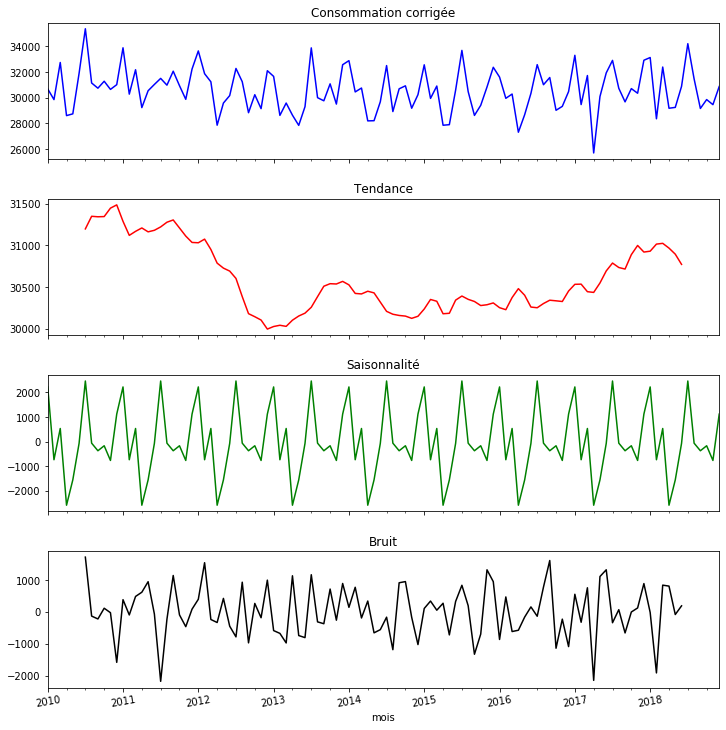

In [30]:
import statsmodels.tsa as tsa

# seasonal_decompose does not accept PeriodIndex
conso_revue = copy.deepcopy(df_all['conso_revue(GWh)'])
conso_revue.index = conso_revue.index.to_timestamp()

decomposition = tsa.seasonal.seasonal_decompose(conso_revue)
 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(10, 10)


conso_revue.plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Consommation corrig√©e')

pd.Series(data=trend, index=conso_revue.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Tendance')

pd.Series(data=seasonal, index=conso_revue.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Saisonnalit√©')

pd.Series(data=residual, index=conso_revue.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Bruit')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.xticks(rotation=10)
plt.show()

L'algorithme a us√© d'une moyenne mobile centr√©e d'ordre 12. Nous pouvons tirer les m√™mes conclusions que sur le graphique pr√©c√©dent. Concernant la saisonnalit√©, il semble qu'elle soit annuelle et additive. Ces informations sont particuli√®rement cruciales pour les mod√©lisations ult√©rieures.

(0.0604577663158713, 0.2)


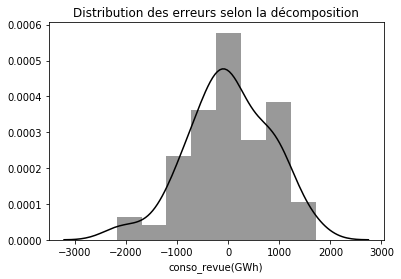

In [31]:
sns.distplot(residual.dropna(), color="black")
plt.title("Distribution des erreurs selon la d√©composition")
print(stats.diagnostic.kstest_normal(residual.dropna(), pvalmethod='approx'))

Le test de Kolmogorov-Smirnov indique que la distribution des r√©sidus suit une loi normale.

# Missions 3 : pr√©vision de la consommation sur un an

Dans cette partie, nous effecturons une pr√©vision de la consommation (corrig√©e de l'effet temp√©rature) sur un an, en utilisant la m√©thode de Holt Winters (lissage exponentiel) puis la m√©thode SARIMA sur la s√©rie temporelle.

## M√©thode de Holt Winters

Le lissage exponentiel de Holt-Winters est un triple lissage exponentiel capable de capturer la tendance et la saisonnalit√© d'une s√©rie temporelle (qu'elles soient multiplicatives ou additives).  Cette technique est populaire et peu gourmande en calculs. Comme le lissage exponentiel simple et double, la m√©thode de Holt-Winters donne aux observations pass√©es un poids d√©croissant exponentiellement avec leur anciennet√©.

Les constantes (alpha, beta et theta) contr√¥lent la vitesse d'apprentissage du mod√®le :
- *alpha* - Ce param√®tre sp√©cifie le coefficient pour le lissage de niveau. *Alpha* est similaire √† une moyenne mobile des observations, il change l'estimation de niveau local. Plus *alpha* est grand, plus il donne de poids aux donn√©es r√©centes. 
- *beta* - C'est le coefficient de la tendance. On peut l'interpr√©ter comme √©tant la moyenne mobile des diff√©rences entre les observations cons√©cutives. Plus *beta* est grand, plus il donne de poids aux donn√©es r√©centes.
- *gamma* - C'est le facteur de lissage pour la composante saisonni√®re. Plus *gamma* est grand, plus il donne de poids aux donn√©es r√©centes.

Ces trois √©l√©ments prennent une valeur entre 0 et 1, il faut les faire varier afin de trouver le meilleur mod√®le. Nous automatisersons cette recherche via un algortithme.

Attention, la m√©thode de Holt-WInters fait quelques hypoth√®ses sur le jeu de donn√©es :
- Une seule tendance.
- La p√©riodicit√© des saisons n'√©volue pas au cours du temps. - Nous sommes dans le cas d'une saisonnalit√© mensuelle. Il faudra fournir cette information √† l'algorithme.
- Pas de donn√©es aberrantes.
- Pas de structure autor√©gressive ou de mod√®le adaptatif.
- Le futur se calque sur le pass√©.
- Les r√©sidus du mod√®le ont une variance constante.

Sources :
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
- https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/
- https://www.youtube.com/watch?v=mrLiC1biciY&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=19
- https://mlcourse.ai/articles/topic9-part1-time-series/
- https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
- https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
- https://stats.stackexchange.com/questions/193901/interpretation-of-level-trend-and-seasonal-indices-in-holt-winters-exponential

In [32]:
# https://mlcourse.ai/articles/topic9-part1-time-series/
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

Avant de construire le mod√®le, discutons d‚Äôabord comment estimer les param√®tres du mod√®le automatiquement. Tout d'abord, nous choisirons une fonction de perte qui indiquera √† quel point le mod√®le se rapproche des donn√©es. Ensuite, en utilisant une validation crois√©e adapt√©e pour les s√©ries chrnonologiques (voir sch√©ma ci-dessous), nous √©valuerons la fonction de perte choisie pour les param√®tres de mod√®le donn√©s, calculerons le gradient, ajusterons les param√®tres de mod√®le, etc. afin de trouver le minimum global.

<img src="Images/time_series_cv.png">

In [33]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

La fonction de perte utilis√©e pour trouver le minimum global est l'erreur quadratique moyenne ("mean squared error" en anglais). Voici sa formule : $MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

D'autre part, nous allons utiliser les 4 derniers mois de 2018 comme test.

In [34]:
data = conso_revue[:-4] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 12 months
model = HoltWinters(data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 16, scaling_factor = 3)
model.triple_exponential_smoothing()

0.03496832373520614 0.0 0.25021544392929496


Le programme a trouv√© le minimum global, les valeurs des diff√©rentes constantes sont :
- *alpha* = 0,035 - Param√®tre quasi-nul, le mod√®le oublie peu le niveau.
- *beta* = 0,0 - C'est le coefficient le mois important des 3. Cela veut dire que rien n'est "oubli√©" pour la tendance
- *gamma* = 0,250 - Le mod√®le "oublie" plus rapidement les donn√©es concernant la saisonnalit√©.

Sources :
- https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/winters-method/interpret-the-results/all-statistics-and-graphs/

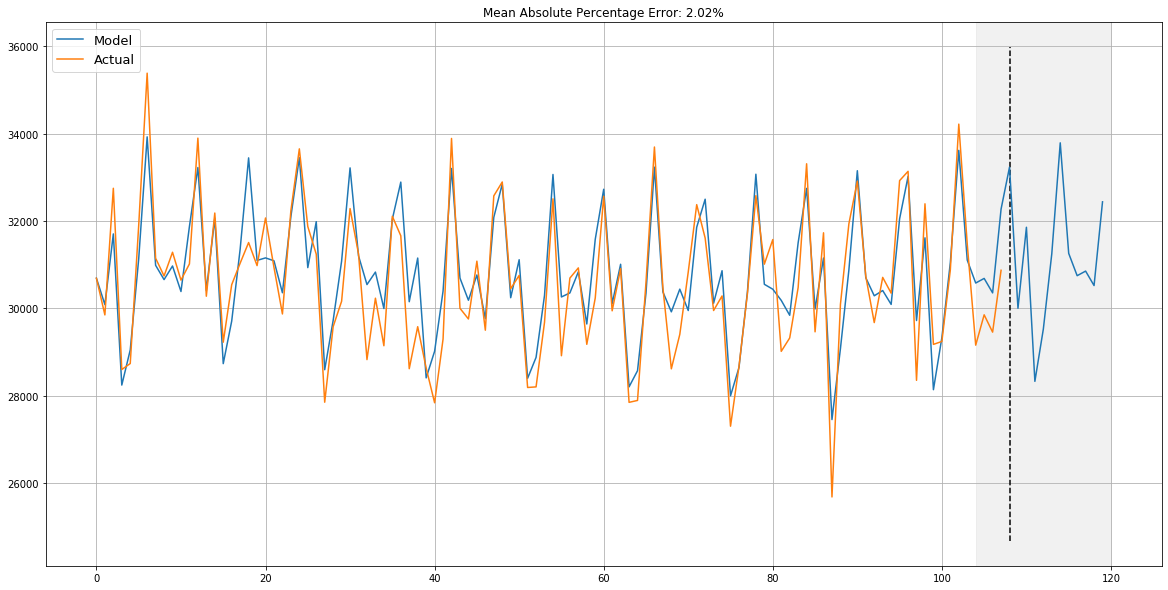

In [35]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-4, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);


plotHoltWinters(conso_revue, plot_intervals=False, plot_anomalies=False)

Il est utile de comparer les valeurs r√©elles et les pr√©dictions du mod√®le. L'√©cart entre les deux constitue une indication indispensable de la pr√©cision d'une m√©thode. Dans ce projet, j'ai d√©cid√© d'utiliser une variation de l'*erreur absolue moyenne*, qui est l'√©cart moyen des valeurs pr√©dites par rapport aux valeurs observ√©es, le *pourcentage d'erreur moyenne absolue*. En effet, il est simple √† comprendre et donne l'occasion de confronter les perfomances de plusieurs proc√©d√©s facilement. Voici la formule de ces deux indicateurs :
- $MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$
- $MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$

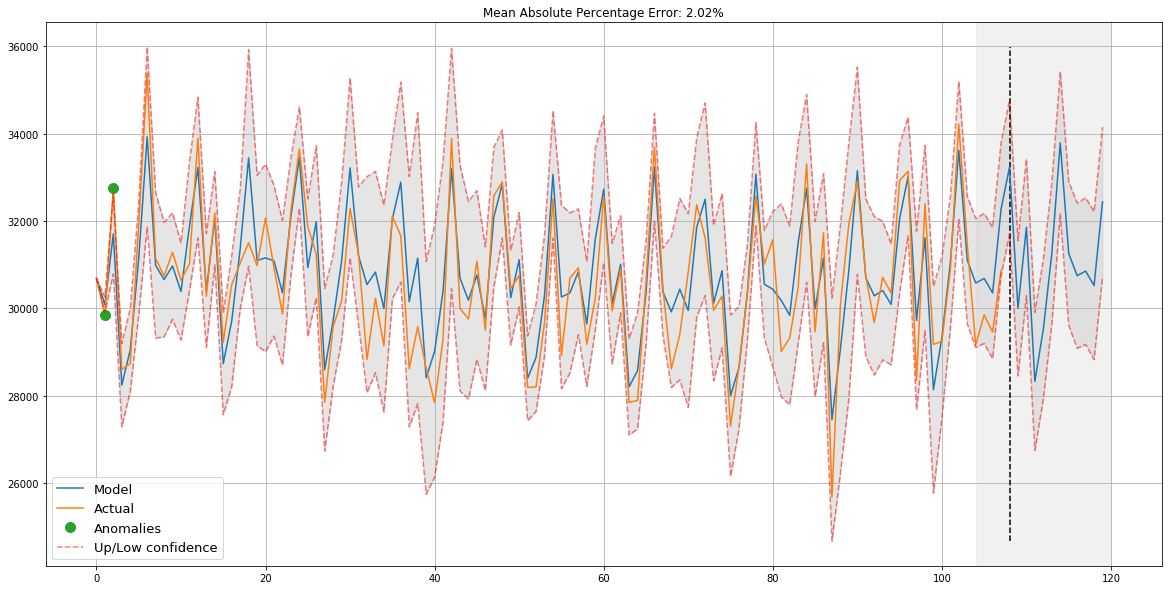

In [36]:
plotHoltWinters(conso_revue, plot_intervals=True, plot_anomalies=True)

Sur les deux graphiques, nous pouvons remarquer que notre mod√®le de Holt-Winters semble proche de la r√©alit√©. Cela est confirm√© par le pourcentage pourcentage d'erreur moyenne absolue qui est faible (environ 2%). On remarque aussi que l'intervalle de confiance varie au cours du temps, c'est normal.

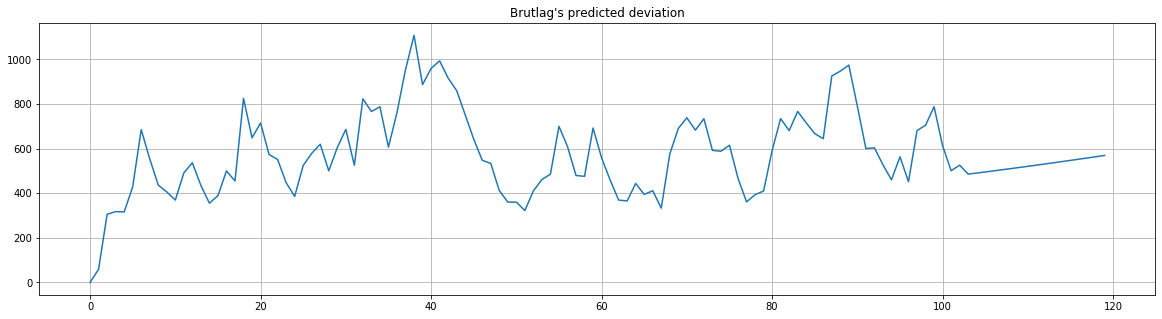

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")
plt.show()

Avant de passer √† la m√©thdoe SARIMA, il est essentiel de comprendre la notion de stationnarit√©. L'infographie ci-dessous d√©taille bien ce concept :

<img src="Images/stationarity.png">

Sources :
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

## M√©thode SARIMA
Nous allons maintenant utliser la m√©thode *SARIMA* ("Seasonnal AutoRegressive Integrated Moving Average" en anglais). Nous allons dans un premier temps parcourir ce mod√®le lettre par lettre:
- *AR(p)* - Un mod√®le similaire √† une r√©gression lin√©aire qui utilise la relation d√©pendante entre une observation et un certain nombre d'observations diff√©r√©es. $Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + \beta_{p}Y_{t-p} + \epsilon_{t}$
- *MA(q)* - Un mod√®le qui utilise la d√©pendance entre une observation et une erreur r√©siduelle d'un mod√®le √† moyenne mobile appliqu√© √† des observations d√©cal√©es.

En combinant ces quatres lettres nous avons *ARMA(p, q)*. Voici sa formule $Y_{t} = \beta_{0} + \beta_{1}Y_{t-1} + \beta_{p}Y_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{q}\epsilon_{t-q}$

Ensuite nous avons :
- *I(d)* - Utilisation de la diff√©renciation d'observations afin de rendre la s√©rie temporelle stationnaire et utiliser l'*ARMA*. En effet, l'ARMA pr√©suppose que les donn√©es sont stationnaires. Le param√®tre *d* correspond au nombre de fois que la diff√©rencation est effectu√©e.
  - d=0: pas de diff√©renciation (pas de tendance) $y_{t} = Y_{t}$
  - d=1: une seule diff√©renciation (tendance lin√©aire) $y_{t} = Y_{t} - Y_{t-1}$
  - d=2: double diff√©renciation $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$

En ajoutant le *I*, nous formons l'*ARIMA(p, d, q)*.

Il me manque plus que la saisonnalit√© :
- *S(s)* - Est √©gale √† longueur d'une saison.

Enfin trois param√®tres suppl√©mentaires sont n√©cessaires pour la m√©thode *SARIMA* :
- *P*  - pareil que *p* mais pour la composante saisonni√®re.
- *Q* - pareil que *q* mais pour la composante saisonni√®re.
- *D* - concerne l'int√©gration de la composante saisonni√®re, prend la valeur 0 (pas de diff√©renciation) ou 1 (diff√©renciation simple).

Pour r√©sumer : $SARIMA(p, d, q)(P, D, Q, s)$. Pour choisir tous ces diff√©rents param√®tres et faire des pr√©dictions, il est judicieux de suivre le processus indiqu√© ci-dessous.

<img src="Images\arima_process.png">

Sources :
- https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#generated-statsmodels-tsa-statespace-sarimax-sarimax--page-root
- https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.minitab.com/fr-fr/Published-Articles/ARIMA%C2%A0--Comment-analyser-des-donn%C3%A9es-de-s%C3%A9rie-chronologique-diff%C3%A9remment%C2%A0-/
- https://people.duke.edu/~rnau/411arim2.htm
- https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

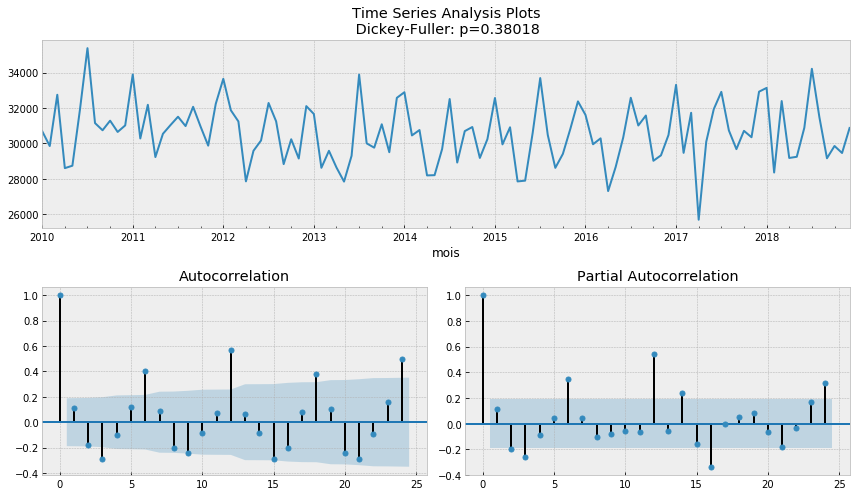

In [38]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey‚ÄìFuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        tsa.api.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        tsa.api.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(conso_revue, lags=24)

Le test de Dickey-Fuller a pour hyptoh√®se nulle que la s√©rie temporelle est non-stationnaire, cette hypoth√®se n'est pas rejet√©e pour l'√©volution de la consommation totale.

Le deuxi√®me graphique, l'ACF, nous permet de visualiser l'auto-Corr√©lation diff√©renci√©e, c-√†-d. les corr√©lations entre des valeurs qui sont s√©par√©es par k p√©riodes. Ainsi, il d√©crit dans quelle mesure la valeur actuelle de la s√©rie est li√©e √† ses valeurs ant√©rieures. La saisonnalit√© annuelle est mis en √©vidence ici.

Le troisi√®me graphique, le PACF ou fonction d‚Äôautocorr√©lation partielle est une mesure de la corr√©lation entre les observations d‚Äôune s√©rie temporelle s√©par√©es par k unit√©s de temps (yt et yt ‚Äì k), apr√®s ajustement pour tenir compte de la pr√©sence de tous les autres termes de retard plus court (yt ‚Äì 1, yt). ‚Äì2, ..., yt ‚Äì k ‚Äì 1).

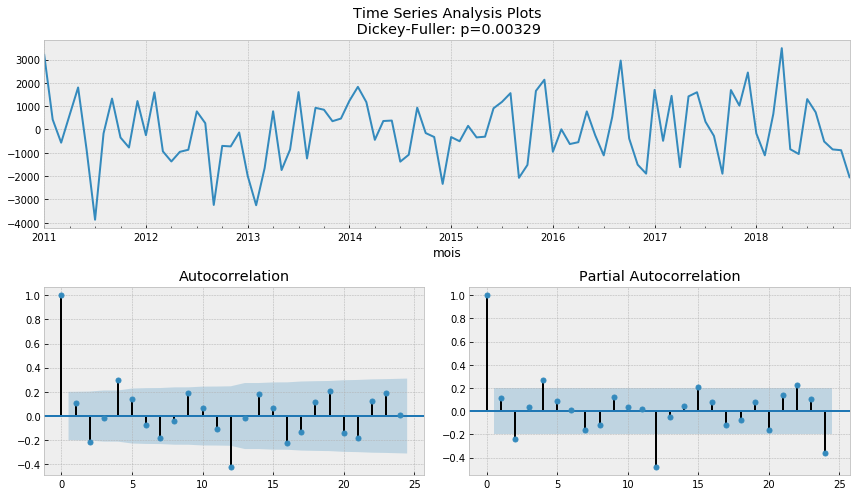

In [39]:
conso_diff = conso_revue - conso_revue.shift(12)
tsplot(conso_diff[12:], lags=24)

Avec un diff√©renciation d'ordre 12, la s√©rie est stationnaire selon le test de Dickey-Fuller. Concernant le choix des param√®tres suite √† l'analyse :
- *p* Entre 2 et 5 selon le PACF 
- *q* Entre 2 et 5 selon l'ACF 
- *d*=0 Pas besoin d'enlever la tendance il n'y en a d√©j√† plus.
- *s*=12
- *P* est certainement √©gal √† 0 ou 1 selon le PACF
- *D*=1 car nous avons r√©alis√© une diff√©renciation saisonni√®re.
- *Q* est probablement 1 car le 12√®me lag sur l'ACF est significatif mais pas le dernier.

Pour faciliter le choix des param√®tres optimaux pour la SARIMA, nous allons l'automatiser via un algorithme.

In [40]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=0 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [41]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=tsa.statespace.sarimax.SARIMAX(conso_revue, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [42]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_


Wall time: 39.7 s


In [43]:
result_table.head()

parameters          aic
0  (3, 3, 1, 1)  1643.024556
1  (3, 3, 0, 0)  1643.846488
2  (4, 2, 0, 0)  1644.838599
3  (3, 3, 1, 0)  1645.163669
4  (3, 3, 0, 1)  1645.581587

In [44]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=tsa.statespace.sarimax.SARIMAX(conso_revue, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\CGRM\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                   conso_revue(GWh)   No. Observations:                  108
Model:             SARIMAX(3, 0, 3)x(1, 1, 1, 12)   Log Likelihood                -812.512
Date:                            Sat, 02 Nov 2019   AIC                           1643.025
Time:                                    11:38:48   BIC                           1666.104
Sample:                                01-01-2010   HQIC                          1652.354
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3415      0.067     19.972      0.000       1.210       1.473
ar.L2         -1.3767      0.043   

Nous allons maintenant inspecter les r√©sidus du mod√®le

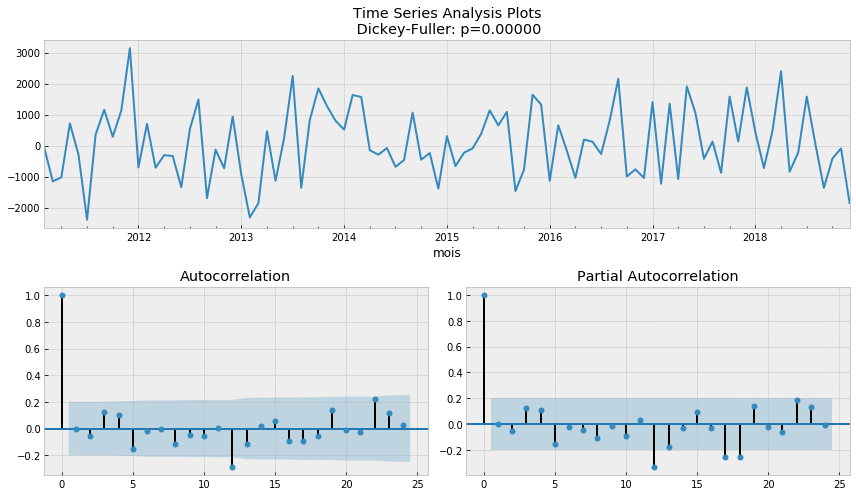

In [45]:
tsplot(best_model.resid[12+1:], lags=24)

Les r√©sidus sont clairement stationnaires et il n'y a pas d'autocorr√©lation apparente. Nous pouvons pr√©dire avec notre mod√®le

2019-01-01    33760.291237
2019-02-01    28824.553563
2019-03-01    31611.509063
2019-04-01    28292.205917
2019-05-01    29581.976331
2019-06-01    31557.762708
2019-07-01    33938.464713
2019-08-01    30646.746743
2019-09-01    29064.127654
2019-10-01    30467.741366
2019-11-01    29988.138784
2019-12-01    30635.225155
2020-01-01    33005.639580
Freq: MS, dtype: float64
2010-01-01             NaN
2010-02-01             NaN
2010-03-01             NaN
2010-04-01             NaN
2010-05-01             NaN
                  ...     
2019-09-01    29064.127654
2019-10-01    30467.741366
2019-11-01    29988.138784
2019-12-01    30635.225155
2020-01-01    33005.639580
Length: 121, dtype: float64


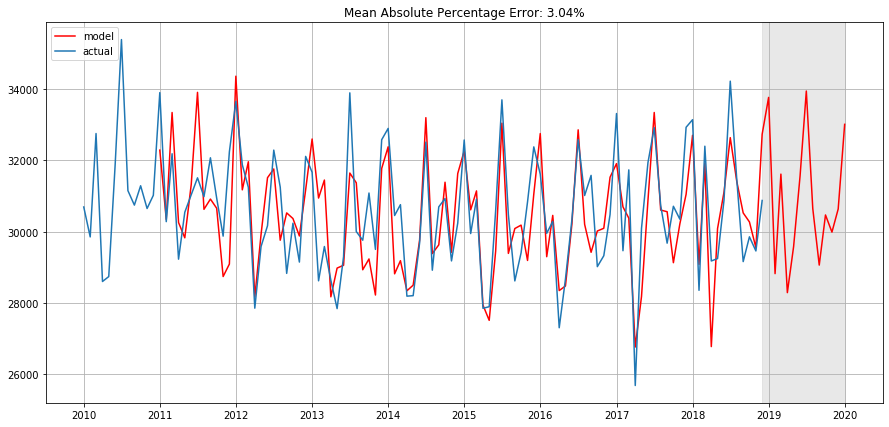

In [46]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.rename('actual', inplace=True)
    #data.rename(index={0: "actual"}, inplace=True)
    data = data.to_frame()
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    print(forecast)
    forecast = data.arima_model.append(forecast)
    print(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(conso_revue, best_model, 12)

Notre mod√®le a une erreur moyenne absolue de 3,04%.